# Reinforcement Learning
## Some pre-requisites if running on Google Collab
If not running on Google collab do not run these next two cells!

In [ ]:
# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b rl-setup https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/src/chessbot .
!rm chessbot-repo -r

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
weights_directory = '/content/gdrive/MyDrive/chessbot_weights/'
print(f'Saving weights to {weights_directory}')

## If you want you save locally run this cell
change file_name to be where the weights could be saved 

In [2]:
weights_directory = 'chessbot_weights/'

## Our model
We will initially be using a MLP Regression model set up with the default parameters from scikit-learn's MLP Regression model since it seems like a solid place to start. After some trial and error, a second Dense layer for the model was added to hopefully capture a bit more complexity.

In [3]:
from tensorflow import keras

model = keras.Sequential([
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

2023-03-11 15:10:17.052727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 15:10:17.222690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 15:10:17.222752: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 15:10:17.831867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Setting the exploration rate
The exploration rate is defined as the chance of randomly making a move instead of relying on the prediction of the model.

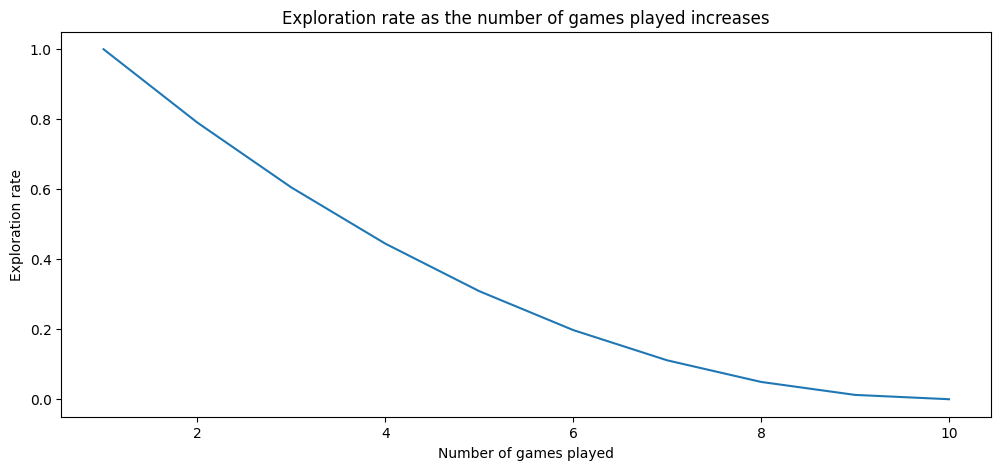

In [4]:
import matplotlib.pyplot as plt
import numpy as np

num_games = 10
exploration_rates = np.linspace(1, 0, num_games)**2

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_xlabel('Number of games played')
ax.set_ylabel('Exploration rate')
ax.plot(np.linspace(1, num_games, num_games), exploration_rates)
ax.set_title('Exploration rate as the number of games played increases')

plt.show()

## Training the model
The model will be trained by playing against itself.

In [5]:
import chess
import numpy as np
from IPython.display import clear_output
from chessbot.chessbot import ChessBot

def play_game_and_learn(model, exploration_rate=0.0, should_visualise=False):
	white = ChessBot(model, chess.WHITE, exploration_rate)
	black = ChessBot(model, chess.BLACK, exploration_rate)

	board = chess.Board()

	if should_visualise:
		display(board)

	while not board.is_game_over(claim_draw=True):
		board.push(black.move(board) if board.turn == chess.BLACK else white.move(board))

		if should_visualise:
			clear_output(wait=True)
			display(board)

	result = board.outcome(claim_draw=True).result()

	# If the game was not a draw train the model
	if result == '1/2-1/2':
		return result, None, None
	
	X = np.empty((len(white.moves_made) + len(black.moves_made), len(white.moves_made[0])))
	y = np.empty_like(X)

	# Blend the moves into a single array with alternating elements
	X[::2] = white.moves_made
	X[1::2] = black.moves_made

	# Set the label for the last move to 1, representing a winning move, then
	# discount the rest as they led to a win but should not be rewarded as heavily
	discount_factor = 0.95
	y_reversed_indices = np.linspace(len(y) - 1, 0, num=len(y))
	y = 1 * discount_factor**y_reversed_indices

	# If black won flip the labels since our model evaluates white's position
	if result == '0-1':
		y *= -1

	# Scale the labels to be between 0 and 1 instead of -1 and 1
	y = (y + 1) / 2
		
	model.fit(X, y)

	return result, X, y

In [ ]:
from IPython.display import clear_output

results = []
white_wins = 0
black_wins = 0
draws = 0

X_all = None
y_all = None

for i in range(num_games):
	clear_output(wait=True)
	if i > 0:
		print(f"The last game's result: {results[-1]}")
	print(f'White wins: {white_wins}, Black wins: {black_wins}, Draws: {draws}')
	print(f'Game {i + 1}/{num_games} (exploration rate: {exploration_rates[i]:.2f})')

	result, X, y = play_game_and_learn(model, exploration_rate=exploration_rates[i])
	results.append(result)

	if X is not None and y is not None:
		if X_all is None:
			X_all = X
			y_all = y
		else:
			X_all = np.concatenate((X_all, X))
			y_all = np.concatenate((y_all, y))

	if result == '1-0':
		white_wins += 1
	if result == '0-1':
		black_wins += 1
	if result == '1/2-1/2':
		draws += 1

	# Save the weights and training data every 100 games
	if (i + 1) % 100 == 0:
		model.save(f'{weights_directory}{i + 1}_games_model')
		np.savez(f'{weights_directory}{i + 1}_games_data.npz', X=X_all, y=y_all)

In [7]:
print(f'White wins: {white_wins}, Black wins: {black_wins}, Draws: {draws}')

White wins: 1, Black wins: 2, Draws: 7


## Why not watch a game after all that training?

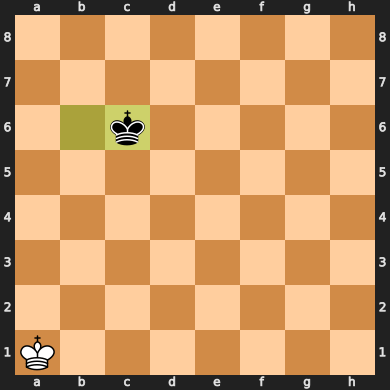

Game result: ('1/2-1/2', None, None)


In [8]:
result = play_game_and_learn(model, should_visualise=True)
print(f'Game result: {result}')